# Post-hoc analyses

Be careful, all the libraries I use a very sensitive to different versions of each other. Here are the versions of the packages I used:
- Python == 3.10.10
- tensorflow == 2.11.0
- tensorflow-io == 0.31.0
- Numpy == 1.23.5
- Matplotlib == 3.7.1
- Jupyter Notebook == 6.5.3

In [2]:
from tensorflow.keras import layers, losses

from model import *

# - Modify the parameters at will -------------------------
nb_samples = 300            # Total number of samples in the dataset
key = "P"                # The key used for generating the data. Datapoints npy files should have the format "key_i.npy" with i the index ranging from 0 to nb_samples.
dataset_dir = "dataset_vector_{}".format(key)
duration = 45               # In seconds, the duration of the total audio segment

training_index = 12         # Index to differentiate training from the others in the logs
epoch_to_load = 45          # Put here the number of the epoch to load

batch_size = 32
latent_dim = 64             # Number of dimensions of the latent spce
cut = int(0.8*nb_samples)   # Defines the train/validation cut. NB: A good cut is generally 80/20 %

## 1. Load the model weights

In [3]:
first = np.load("{}/{}_0.npy".format(dataset_dir, key))  # Load the first datapoint to retrieve the shape
data_shape = first.shape    # Shape for the whole dataset
print(data_shape)

time_stamps = np.load("miscellaneous/time_stamps_{}.npy".format(key))
spec_indices = np.load("miscellaneous/spectrogram_indices_{}.npy".format(key))

dataset = np.zeros((nb_samples, data_shape[0], data_shape[1]))  # Create the empty vector that will hold the full data
dataset[0] = first

for i in range(1, nb_samples):
    dataset[i] = np.load("{}/{}_{}.npy".format(dataset_dir, key, i))

dataset = dataset.reshape((nb_samples, data_shape[0], data_shape[1], 1))

autoencoder = Autoencoder(data_shape, latent_dim)
autoencoder.compile(optimizer="adam",
                    loss=losses.MeanSquaredError())
autoencoder.build((None, data_shape[0], data_shape[1], 1))

autoencoder.summary()

autoencoder.load_weights("logs/training_{}/cp-00{}.ckpt".format(training_index, epoch_to_load))

encoded_dataset = autoencoder.encoder(dataset)

(2504, 48)
Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  6445568   
                                                                 
 decoder (Decoder)           multiple                  7905089   
                                                                 
Total params: 14,350,657
Trainable params: 14,350,657
Non-trainable params: 0
_________________________________________________________________


## 2. Hierarchical clustering
The cut distance defines where the clustering is cut to make the individual clusters

In [4]:
# - Modify the parameters at will -------------------------
cut_distance = 1700

The following code was copied from [this](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py) tutorial by Sklearn and then modified:

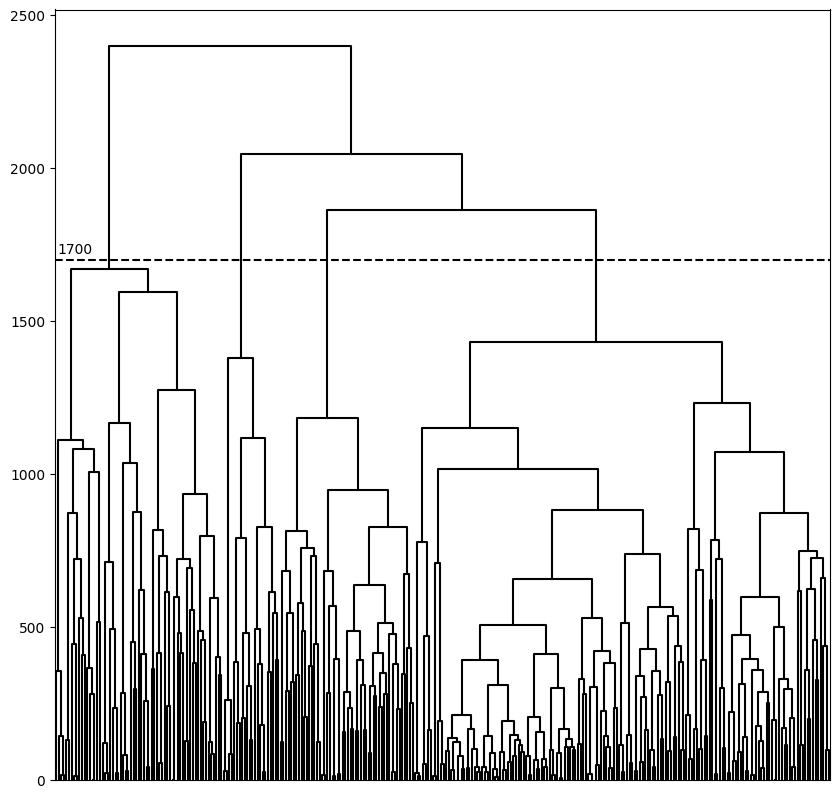

Number of clusers with the given cut distance:  4


In [8]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import set_link_color_palette
from sklearn.cluster import AgglomerativeClustering

set_link_color_palette(["black"])   # This sets the color of the dendrogram
# NB: The dendogram function colors the clusters in merging distance order, which does not necessarily correspond to the order of the labeling of the clusters. For this reason, I chose to display the dendrogram in black and plot colours only on the density graph (below)

def plot_dendrogram(model, cut_distance, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, no_labels=True, color_threshold=cut_distance, above_threshold_color="black", **kwargs)


agglo = AgglomerativeClustering(
        n_clusters=None,
        distance_threshold=cut_distance,
        linkage="ward",
        compute_distances=True
        )
plt.figure(figsize=(10,10))
agglo.fit(encoded_dataset)
plot_dendrogram(agglo, cut_distance, truncate_mode=None)
plt.axhline(y = cut_distance, color = 'black', linestyle = '--')
plt.text(10, cut_distance+20, "{}".format(cut_distance))
plt.show()

print("Number of clusers with the given cut distance: ", agglo.n_clusters_)

### Visualize cluster elements on the timeline

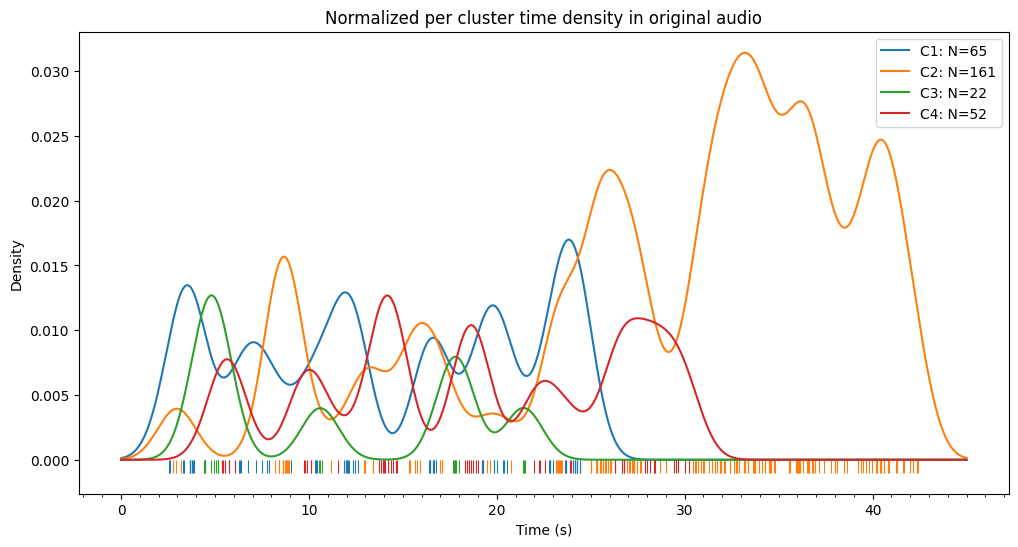

In [9]:
from sklearn.neighbors import KernelDensity
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
floor = np.linspace(0, duration, 100000)[:, np.newaxis]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Since the dendogram uses basic matplotlib colours, and uses the first one for the branches above, we need to skip a colour to have matching colours on the graph below and the dendogram.
fig, ax = plt.subplots(figsize=(12,6))
for i in range(agglo.n_clusters_):
    cluster_samples = time_stamps[agglo.labels_==i]+2.5
    kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(cluster_samples[:,np.newaxis])
    log_dens = kde.score_samples(floor)
    n_i = np.sum(agglo.labels_==i)

    plt.plot(floor, (n_i/agglo.n_leaves_)*np.exp(log_dens), label="C{}: N={}".format(i+1, n_i), color=colors[i])
    plt.vlines(cluster_samples, -1e-3, 0, linewidth=0.8, color=colors[i])
plt.title("Normalized per cluster time density in original audio")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Density")
ax.xaxis.set_minor_locator(MultipleLocator(1))

## Zoom in and observe the spectrogram related to a region

In [31]:
# - Modify the parameters at will -------------------------
cut_time = 10         # Where to cut
cut_length = 10          # For how long

(10.0, 20.0)

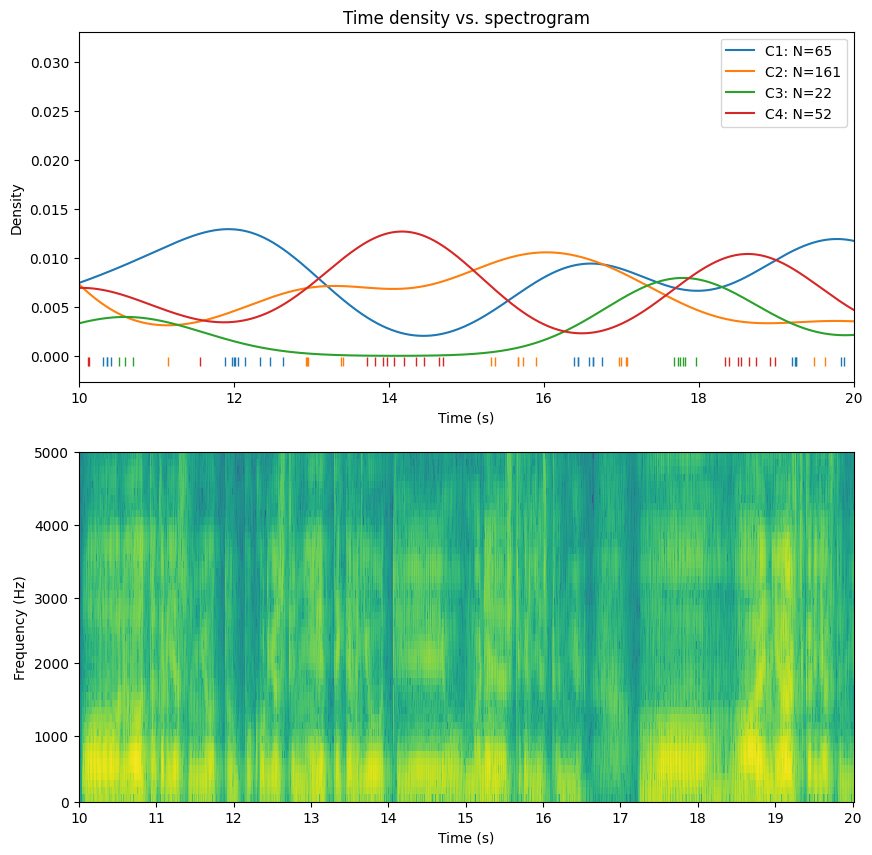

In [32]:
from sklearn.neighbors import KernelDensity
floor = np.linspace(0, 60, 100000)[:, np.newaxis]
second_coef = 2504/5    # Coefficient to transform length in seconds to number of pixels
full_spec = np.load("miscellaneous/spectro_{}.npy".format(key))       # Load the full spectrogram

plt.figure(figsize=(cut_length,10))
plt.subplot(212)

plt.pcolormesh(full_spec)
plt.xlim(cut_time*second_coef, cut_time*second_coef + cut_length*second_coef)
plt.xticks([cut_time*second_coef +500*i for i in range(cut_length+1)], [cut_time+i for i in range(cut_length+1)])
plt.yticks([int(9.6*i) for i in range(6)], [1000*i for i in range(6)])
plt.ylim(0,48)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

plt.subplot(211)
for i in range(agglo.n_clusters_):
    cluster_samples = time_stamps[agglo.labels_==i]+2.5
    kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(cluster_samples[:,np.newaxis])
    log_dens = kde.score_samples(floor)
    n_i = np.sum(agglo.labels_==i)

    plt.plot(floor, (n_i/agglo.n_leaves_)*np.exp(log_dens), label="C{}: N={}".format(i+1, n_i), color=colors[i])
    plt.vlines(cluster_samples, -1e-3, -1e-4, linewidth=1, color=colors[i])

plt.title("Time density vs. spectrogram")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Density")
plt.xlim(cut_time, cut_time+cut_length)


### Plot a representative sample of the clusters datapoints

In [29]:
# - Modify the parameters at will -------------------------
samples_from_clusters = 3      # Number of samples to take from each cluster


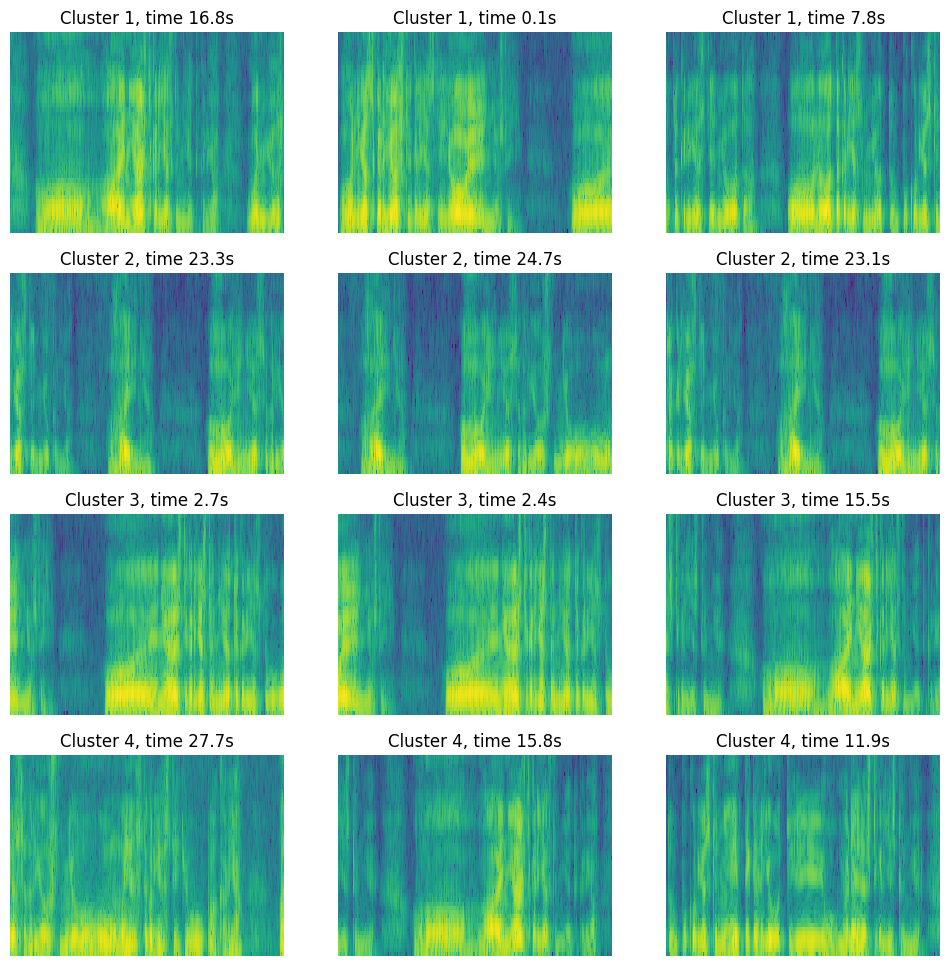

In [30]:
index_list = np.array([])
for i in range(agglo.n_clusters_):  # This selects indices corresponding to 3 randomly-drawn elements in every cluster
    current = np.random.choice(np.where(agglo.labels_==i)[0], samples_from_clusters, False)
    index_list = np.hstack((index_list, current))

plt.figure(figsize=(4*samples_from_clusters, 3*agglo.n_clusters_))

for i, index in enumerate(index_list.astype("int")):
    plt.subplot(agglo.n_clusters_,samples_from_clusters,i+1)
    plt.title("Cluster {}, time {}s".format(int(np.floor(i/samples_from_clusters)+1), np.round(time_stamps[index], 1)))
    plt.pcolormesh(np.log(np.reshape(dataset[index], (data_shape[0],data_shape[1])).T))
    #plt.xticks([500*i for i in range(6)], [np.round(time_stamps[index], 1)+i for i in range(6)])
    #plt.yticks([int(9.6*i) for i in range(6)], [1000*i for i in range(6)])
    plt.axis("off")